## 1st Iteration - Run on 1000 sample

### data & imports

In [143]:
import pandas as pd
import re
import json
import os
import math
from openai import OpenAI
from dotenv import load_dotenv
import time

In [144]:
df = pd.read_csv("Project_Sandals_Google_Reviews_V2.csv")
df['reviews_id'] = df.index + 1
df.dropna(subset='review_text', inplace=True)
df = df.sample(1000)
reviews_df = df[['review_text','reviews_id']]

In [145]:
reviews_df.shape

(1000, 2)

In [146]:
def clean_review(text):
    text = re.sub(r"<.*?>", "", text)
    text = text.replace("\n", " ").strip()
    return text

reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2039213048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)


In [147]:
reviews_df['sentiment'] = None
reviews_df['topic'] = None
reviews_df['support_text'] = None
reviews_df['translated_review_text'] = None

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2612990079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2612990079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['topic'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2612990079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

### batch api

#### create batch

In [ ]:
MAX_REQUESTS_PER_BATCH = 50000
MAX_BATCH_SIZE_BYTES = 190 * 1024 * 1024  #keeping max size 190mb

def build_request_line(review_id, review_text):

    # system_prompt = (
    # "You are a helpful assistant that analyzes customer reviews.\n"
    # "For each review:\n"
    # "- If the review is not in English, translate it to English first and include the translated text.\n"
    # "  If it's already in English, keep it as is and set translated_text to the original.\n"
    # "- Use the English version of the review to:\n"
    # "  - Determine the sentiment (Positive, Neutral, or Negative).\n"
    # "  - Identify a short topic label from the following list:\n"
    # "  - Extract a short **exact phrase** (verbatim) from the English text that supports the topic.\n\n"
    # "Return ONLY a strict JSON object with the following format (no explanations, no extra text):\n"
    # '{"translated_text": "...", "sentiment": "...", "topic": "...", "support_text": "..."}'
    # )

    system_prompt = (
        "You are a helpful assistant that analyzes customer reviews.\n"
        "For each review:\n"
        "- If the review is not in English, translate it to English and include the translated text.\n"
        "  If it is already in English, keep it as is and set translated_text to the original.\n"
        "- Use the English version of the review to identify a short topic label.\n"
        "Return ONLY a strict JSON object with no explanations or extra text, in this exact format:\n"
        '{"translated_text": "...", "topic": "..."}'
    )

    
    request_body = {
        "custom_id": str(review_id),
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-4o-mini",
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Review: {review_text}"}
            ],
            "max_tokens": 1024,         #increased token length as getting None in sentiment, topic & support text
            "temperature": 0.0
        }
    }
    return json.dumps(request_body)


batch_num = 1
batch_lines = []
batch_size_bytes = 0

for idx, row in reviews_df.iterrows():
    line = build_request_line(row['reviews_id'], row['review_text']) + "\n"
    line_size = len(line.encode('utf-8'))

    # Check if adding this line exceeds limits
    if (len(batch_lines) >= MAX_REQUESTS_PER_BATCH) or (batch_size_bytes + line_size > MAX_BATCH_SIZE_BYTES):
        # Write current batch to file
        batch_file = f"batchinput_part{batch_num}.jsonl"
        with open(batch_file, "w", encoding="utf-8") as f:
            f.writelines(batch_lines)
        print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")

        # Reset for next batch
        batch_num += 1
        batch_lines = []
        batch_size_bytes = 0

    # Add current line to batch
    batch_lines.append(line)
    batch_size_bytes += line_size

# Save the last batch if any lines left
if batch_lines:
    batch_file = f"batchinput_part{batch_num}.jsonl"
    with open(batch_file, "w", encoding="utf-8") as f:
        f.writelines(batch_lines)
    print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")


Saved batch 1 with 1000 lines (1.40 MB) to 'batchinput_part1.jsonl'


#### upload batch

In [149]:
[f"batchinput_part{i}.jsonl" for i in range(1, batch_num + 1)]

['batchinput_part1.jsonl']

In [150]:
load_dotenv()
openai = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

batch_job_ids = []

# Assume batch_num is the number of batches you created before
batch_files = [f"batchinput_part{i}.jsonl" for i in range(1, batch_num + 1)]

for bf in batch_files:
    # Upload the batch file
    with open(bf, "rb") as f:
        upload_response = openai.files.create(
            file=f,
            purpose="batch",
        )
    input_file_id = upload_response.id
    print(f"Uploaded {bf} with file id: {input_file_id}")

    # Create a batch job for this uploaded file
    batch_response = openai.batches.create(
    input_file_id=input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    )

    print(f"Created batch job for {bf} with job id: {batch_response.id}")
    batch_job_ids.append(batch_response.id)

Uploaded batchinput_part1.jsonl with file id: file-Wzfx5sy5NzkyD4V5z67qTx
Created batch job for batchinput_part1.jsonl with job id: batch_68789fb4b00081908db17d7c26ca8803


#### download batch output

In [151]:
def poll_and_download(batch_id):
    print(f"Polling batch job {batch_id}...")
    while True:
        batch_info = openai.batches.retrieve(batch_id)
        status = batch_info.status
        print(f"Status of batch {batch_id}: {status}")
        if status in ["completed", "failed", "cancelled", "expired"]:
            break
        time.sleep(10)

    if status != "completed":
        print(f"Batch {batch_id} ended with status {status}. Skipping download.")
        return {}

    output_file_id = batch_info.output_file_id
    print(f"Downloading results for batch {batch_id} with file id {output_file_id}...")

    output_file_response = openai.files.content(output_file_id)
    output_lines = output_file_response.text.splitlines()

    results = {}
    for line in output_lines:
        try:
            result_json = json.loads(line)
            custom_id = result_json.get("custom_id")
            response_body = result_json.get("response", {}).get("body", {})
            choices = response_body.get("choices", [])
            if choices:
                content = choices[0]["message"]["content"]
                try:
                    parsed_content = json.loads(content)
                except json.JSONDecodeError:
                    parsed_content = {
                        "error": "Invalid JSON in GPT response",
                        "raw_content": content
                    }
                results[custom_id] = parsed_content
            else:
                results[custom_id] = {"error": "No choices in response"}
        except Exception as e:
            print(f"Error parsing line in batch {batch_id}: {e}")
    return results


In [152]:
all_results = {}
for job_id in batch_job_ids:
    batch_results = poll_and_download(job_id)
    all_results.update(batch_results)

print(f"Total results fetched: {len(all_results)}")

for col in ['sentiment', 'topic', 'support_text']:
    if col not in reviews_df.columns:
        reviews_df[col] = None

for cid, res in all_results.items():
    if "error" in res:
        continue  # skip errored entries
    
    sentiment = res.get("sentiment")
    topic = res.get("topic")
    support_text = res.get("support_text")
    translated_text = res.get("translated_text")

    mask = reviews_df['reviews_id'].astype(str) == cid
    
    # Update sentiment, topic, support_text
    reviews_df.loc[mask, 'sentiment'] = sentiment
    reviews_df.loc[mask, 'topic'] = topic
    reviews_df.loc[mask, 'support_text'] = support_text

    # Update review_text if translated_text is present and different
    if translated_text and translated_text.strip() and translated_text.strip() != reviews_df.loc[mask, 'review_text'].values[0].strip():
        reviews_df.loc[mask, 'review_text'] = translated_text.strip()

Polling batch job batch_68789fb4b00081908db17d7c26ca8803...
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: in_progress
Status of batch batch_68789fb4b00081908db17d7c26ca8803: 

In [153]:
reviews_df

,review_text,reviews_id,sentiment,topic,support_text,translated_review_text
6527,"Isabel and Martina are very good cooks, and Wi...",6528,Positive,Service,the experience with the staff and the hotel fa...,None
2549,Spent the week surrounding Thanksgiving during...,2550,Positive,Overall experience,Overall my wife and I had an absolute amazing ...,None
13028,Galley Bay Resort and Spa is a wonderful place...,13029,Positive,Hospitality,the warm hospitality await u there,None
5281,Great place for dun in the sun and gamblin in ...,5282,Positive,Entertainment,Great place for dun in the sun and gamblin in ...,None
12784,Detailed review alert 🚨 First time visiting An...,12785,Positive,Food and Service,Boy was this stay worth every penny!!!,None
...,...,...,...,...,...,...
12186,"Beautiful facility, good food. Only the one be...",12187,Neutral,Facility and Food,"Beautiful facility, good food.",None
686,Sandals curaçao was amazing! The food was deli...,687,Positive,Service,the staff were all extremely friendly,None
2979,Outstanding,2980,Positive,Quality,Outstanding,None
5479,friendly staff BEAUTIFUL hotel.,5480,Positive,Staff,friendly staff,None


#### extarct topics

In [155]:
input_topics = reviews_df['topic'].dropna().unique().tolist()

In [161]:
input_topics

['Service',
 'Overall experience',
 'Hospitality',
 'Entertainment',
 'Food and Service',
 'Quality',
 'Staff Service',
 'Hotel Experience',
 'Customer Service',
 'Satisfaction',
 'Experience',
 'Accommodation',
 'Overall Experience',
 'Service Issues',
 'Wedding Experience',
 'Amenities',
 'Location',
 'Butler Service',
 'Hotel Quality',
 'Insufficient loungers',
 'Dining Experience',
 'Honeymoon Experience',
 'Staff',
 'Resort Experience',
 'Service and Amenities',
 'Service Quality',
 'Ambiance',
 'Room quality',
 'Stay Experience',
 'Spa Experience',
 'Beach Quality',
 'Casino Experience',
 'Honeymoon experience',
 'Safety',
 'Nature Experience',
 'Staff Attitude',
 'Staff Disorganization',
 'Fun activities',
 'Food Quality',
 'Vacation Experience',
 'Beauty',
 'Billing Issues',
 'Staff and Service',
 'Resort Quality',
 'Travel Experience',
 'General',
 'Enjoyment',
 'Recommendation',
 'Beach Experience',
 'Food options',
 'VIP experience',
 'Staff Training',
 'Comfort and Service'

In [ ]:
###chatgpt prompt to create a concise list using above list from : reviews_df['topic'].dropna().unique().tolist()

# You are a data analyst assisting with text clustering.

# Given a list of specific review topic phrases, your task is to:
# 1. Identify common semantic themes shared across the list.
# 2. Merge overlapping topics and group them under broader, high-level categories.
# 3. Return a concise list of unique, generalized topic labels (each 1–3 words long). 
# 4. Avoid repeating similar concepts with different wording — generalize wherever possible.
# 5. Output only a clean Python list of the merged topics.

# Input:
# <input list>

# Return:
# A Python list named `broader_topics` containing the merged, high-level categories.

In [ ]:
import ast

broader_topics_system_prompt = f"""
You are a data analyst helping to organize and simplify topic lists.

Given a list of specific review topic phrases (which may be long and contain overlapping or similar items), your task is to:

1. Identify the main semantic themes and group similar or overlapping topics together.
2. Create a concise list of broader, high-level topic labels (each label should be 1–3 words long).
3. Avoid repeating similar concepts with different wording — generalize wherever possible.
4. Output ONLY a single line of valid Python code assigning a list of these broader topics to a variable named `broader_topics`.
5. Do NOT include explanations, comments, or any extra text."""

user_prompt_text = f"Input:\n{input_topics}\n\nReturn only valid Python code: `broader_topics = [...]`"

api_response = openai.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": broader_topics_system_prompt.strip()},
        {"role": "user", "content": user_prompt_text.strip()}
    ],
    temperature=0
)

gpt_output = api_response.choices[0].message.content

try:
    if gpt_output.startswith("broader_topics"):
        rhs = gpt_output.split("=", 1)[1].strip()
        broader_topics = ast.literal_eval(rhs)
        print("Extracted broader_topics:", broader_topics)
    else:
        raise ValueError("Response does not define 'broader_topics'")
except Exception as e:
    print("Failed to parse GPT output:", e)
    broader_topics = []


Extracted broader_topics: ['Service', 'Experience', 'Quality', 'Food', 'Location', 'Staff', 'Amenities', 'Cleanliness', 'Value', 'Entertainment', 'Safety', 'Facilities', 'Romance', 'General Feedback', 'Management', 'Accessibility', 'Environment']


In [165]:
broader_topics

['Service',
 'Experience',
 'Quality',
 'Food',
 'Location',
 'Staff',
 'Amenities',
 'Cleanliness',
 'Value',
 'Entertainment',
 'Safety',
 'Facilities',
 'Romance',
 'General Feedback',
 'Management',
 'Accessibility',
 'Environment']

In [169]:
broader_topics.append("others")

In [168]:
# manual_list = [
#     "Service",
#     "Customer Experience",
#     "Staff",
#     "Hotel Quality",
#     "Accommodation",
#     "Food and Dining",
#     "Amenities",
#     "Location",
#     "Experience",
#     "Safety",
#     "Cleanliness",
#     "Facilities",
#     "Entertainment",
#     "Resort",
#     "Pricing and Value",
#     "Connectivity",
#     "Maintenance and Renovation",
#     "Environment and Ambiance",
#     "Events and Celebrations",
#     "Shopping",
#     "Spa and Relaxation",
#     "Accessibility",
#     "Management",
#     "Technology",
#     "General Feedback"
# ]

## 2nd Iteration - Run for "broader topics" on full dataset
- (taking 5000 rows as full dataset)

### data

In [203]:
df = pd.read_csv("Project_Sandals_Google_Reviews_V2.csv")
df['reviews_id'] = df.index + 1
df.dropna(subset='review_text', inplace=True)
df = df.sample(5000)
reviews_df = df[['review_text','reviews_id']]

In [204]:
def clean_review(text):
    text = re.sub(r"<.*?>", "", text)
    text = text.replace("\n", " ").strip()
    return text


In [205]:
reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\1605087330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)


In [206]:
reviews_df['sentiment'] = None
reviews_df['topic'] = None
reviews_df['support_text'] = None
reviews_df['translated_review_text'] = None

C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2612990079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2612990079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['topic'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\2612990079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [207]:
reviews_df

,review_text,reviews_id,sentiment,topic,support_text,translated_review_text
10499,"The hotel was very nice, liked the location. ...",10500,None,None,None,None
2265,Loved it! Perfect for our Honeymoon. 🌙Big reso...,2266,None,None,None,None
7467,Lekker bakkie doen,7468,None,None,None,None
2019,Not first trip to a Sandals resort but overall...,2020,None,None,None,None
13154,Excellent staff and a 5 star resort,13155,None,None,None,None
...,...,...,...,...,...,...
12186,"Wunderschöne Anlage, gutes Essen. Einzig der e...",12187,None,None,None,None
5088,Just had breakfast with friends for my birthda...,5089,None,None,None,None
9572,"Honestly one of the best vacations, the resort...",9573,None,None,None,None
6265,Amazing experience,6266,None,None,None,None


### batch api

#### create batch

In [213]:
broader_topics = [
    'Service',
    'Experience',
    'Quality',
    'Location',
    'Staff',
    'Amenities',
    'Safety',
    'Management',
]

In [214]:
broader_topics.append('Other')      #adding rest as other

In [215]:
topics_str = ", ".join(f'"{topic}"' for topic in broader_topics)

In [216]:
topics_str

'"Service", "Experience", "Quality", "Location", "Staff", "Amenities", "Safety", "Management", "Other"'

In [217]:
MAX_REQUESTS_PER_BATCH = 50000
MAX_BATCH_SIZE_BYTES = 190 * 1024 * 1024  #keeping max size 190mb

def build_request_line(review_id, review_text):
    # system_prompt = (
    # "You are a helpful assistant that analyzes customer reviews.\n"
    # "For each review:\n"
    # "- If the review is not in English, translate it to English first and include the translated text.\n"
    # "  If it's already in English, keep it as is and set translated_text to the original.\n"
    # "- Use the English version of the review to:\n"
    # "  - Determine the sentiment (Positive, Neutral, or Negative).\n"
    # f"  - Identify a short topic label from the following list: [{topics_str}]\n"
    # "  - Extract a short **exact phrase** (verbatim) from the English text that supports the topic.\n\n"
    # "Return ONLY a strict JSON object with the following format (no explanations, no extra text):\n"
    # '{"translated_text": "...", "sentiment": "...", "topic": "...", "support_text": "..."}'
    # )


    system_prompt = (
    "You are a helpful assistant that analyzes customer reviews.\n"
    "For each review:\n"
    "- If the review is not in English, translate it to English first and include the translated text.\n"
    "  If it's already in English, keep it as is and set translated_text to the original.\n"
    "- Use the English version of the review to:\n"
    "  - Determine the sentiment score as a number between -1.0 (very negative) and 1.0 (very positive).\n"
    "    - Use negative numbers for negative sentiment, positive numbers for positive sentiment.\n"
    "    - Use 0.0 for neutral or balanced reviews.\n"
    f"  - Identify a short topic label from the following list: [{topics_str}]\n"
    "  - Extract a short **exact phrase** (verbatim) from the English text that supports the topic.\n\n"
    "Return ONLY a strict JSON object with the following format (no explanations, no extra text):\n"
    '{"translated_text": "...", "sentiment": ..., "topic": "...", "support_text": "..."}'
    )

    
    request_body = {
        "custom_id": str(review_id),
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-4o-mini",
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Review: {review_text}"}
            ],
            "max_tokens": 1024,         #increased token length as getting None in sentiment, topic & support text
            "temperature": 0.0
        }
    }
    return json.dumps(request_body)


batch_num = 1
batch_lines = []
batch_size_bytes = 0

for idx, row in reviews_df.iterrows():
    line = build_request_line(row['reviews_id'], row['review_text']) + "\n"
    line_size = len(line.encode('utf-8'))

    # Check if adding this line exceeds limits
    if (len(batch_lines) >= MAX_REQUESTS_PER_BATCH) or (batch_size_bytes + line_size > MAX_BATCH_SIZE_BYTES):
        # Write current batch to file
        batch_file = f"batchinput_part{batch_num}.jsonl"
        with open(batch_file, "w", encoding="utf-8") as f:
            f.writelines(batch_lines)
        print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")

        # Reset for next batch
        batch_num += 1
        batch_lines = []
        batch_size_bytes = 0

    # Add current line to batch
    batch_lines.append(line)
    batch_size_bytes += line_size

# Save the last batch if any lines left
if batch_lines:
    batch_file = f"batchinput_part{batch_num}.jsonl"
    with open(batch_file, "w", encoding="utf-8") as f:
        f.writelines(batch_lines)
    print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")


Saved batch 1 with 5000 lines (8.27 MB) to 'batchinput_part1.jsonl'


#### upload batch

In [218]:
load_dotenv()
openai = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

batch_job_ids = []

# Assume batch_num is the number of batches you created before
batch_files = [f"batchinput_part{i}.jsonl" for i in range(1, batch_num + 1)]

for bf in batch_files:
    # Upload the batch file
    with open(bf, "rb") as f:
        upload_response = openai.files.create(
            file=f,
            purpose="batch",
        )
    input_file_id = upload_response.id
    print(f"Uploaded {bf} with file id: {input_file_id}")

    # Create a batch job for this uploaded file
    batch_response = openai.batches.create(
    input_file_id=input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    )

    print(f"Created batch job for {bf} with job id: {batch_response.id}")
    batch_job_ids.append(batch_response.id)

Uploaded batchinput_part1.jsonl with file id: file-NLy1LpDb3Qy1CxAnYyC6r4
Created batch job for batchinput_part1.jsonl with job id: batch_6878c79a1aa88190acd14561008dc406


#### download batch output

In [196]:
def poll_and_download(batch_id):
    print(f"Polling batch job {batch_id}...")
    while True:
        batch_info = openai.batches.retrieve(batch_id)
        status = batch_info.status
        print(f"Status of batch {batch_id}: {status}")
        if status in ["completed", "failed", "cancelled", "expired"]:
            break
        time.sleep(10)

    if status != "completed":
        print(f"Batch {batch_id} ended with status {status}. Skipping download.")
        return {}

    output_file_id = batch_info.output_file_id
    print(f"Downloading results for batch {batch_id} with file id {output_file_id}...")

    output_file_response = openai.files.content(output_file_id)
    output_lines = output_file_response.text.splitlines()

    results = {}
    for line in output_lines:
        try:
            result_json = json.loads(line)
            custom_id = result_json.get("custom_id")
            response_body = result_json.get("response", {}).get("body", {})
            choices = response_body.get("choices", [])
            if choices:
                content = choices[0]["message"]["content"]
                try:
                    parsed_content = json.loads(content)
                except json.JSONDecodeError:
                    parsed_content = {
                        "error": "Invalid JSON in GPT response",
                        "raw_content": content
                    }
                results[custom_id] = parsed_content
            else:
                results[custom_id] = {"error": "No choices in response"}
        except Exception as e:
            print(f"Error parsing line in batch {batch_id}: {e}")
    return results


In [220]:
all_results = {}

for job_id in batch_job_ids:
    batch_results = poll_and_download(job_id)
    all_results.update(batch_results)

print(f"Total results fetched: {len(all_results)}")

for col in ['sentiment', 'topic', 'support_text']:
    if col not in reviews_df.columns:
        reviews_df[col] = None

for cid, res in all_results.items():
    if "error" in res:
        continue  # skip errored entries
    
    sentiment = res.get("sentiment")
    topic = res.get("topic")
    support_text = res.get("support_text")
    translated_text = res.get("translated_text")

    mask = reviews_df['reviews_id'].astype(str) == cid
    
    # Update sentiment, topic, support_text
    reviews_df.loc[mask, 'sentiment'] = sentiment
    reviews_df.loc[mask, 'topic'] = topic
    reviews_df.loc[mask, 'support_text'] = support_text

    # Update review_text if translated_text is present and different
    if translated_text and translated_text.strip() and translated_text.strip() != reviews_df.loc[mask, 'review_text'].values[0].strip():
        reviews_df.loc[mask, 'review_text'] = translated_text.strip()

Polling batch job batch_6878c79a1aa88190acd14561008dc406...
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: in_progress
Status of batch batch_6878c79a1aa88190acd14561008dc406: 

### Result

In [222]:
reviews_df

,review_text,reviews_id,sentiment,topic,support_text,translated_review_text
10499,"The hotel was very nice, liked the location. H...",10500,-0.6,Service,so disappointed by the service,None
2265,Loved it! Perfect for our Honeymoon. 🌙Big reso...,2266,1.0,Experience,Perfect for our Honeymoon.,None
7467,Nice cup of coffee,7468,0.5,Experience,Nice cup of coffee,None
2019,Not first trip to a Sandals resort but overall...,2020,0.3,Staff,"Staff welcoming, friendly and willing although...",None
13154,Excellent staff and a 5 star resort,13155,1.0,Staff,Excellent staff,None
...,...,...,...,...,...,...
12186,"Beautiful facility, good food. Only the one be...",12187,0.3,Quality,good food,None
5088,Just had breakfast with friends for my birthda...,5089,0.8,Service,friendly service,None
9572,"Honestly one of the best vacations, the resort...",9573,0.9,Experience,one of the best vacations,None
6265,Amazing experience,6266,1.0,Experience,Amazing experience,None


C:\Users\prjain\AppData\Local\Temp\ipykernel_28108\3384443372.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment_label'] = reviews_df['sentiment'].astype(float).apply(categorize_sentiment)


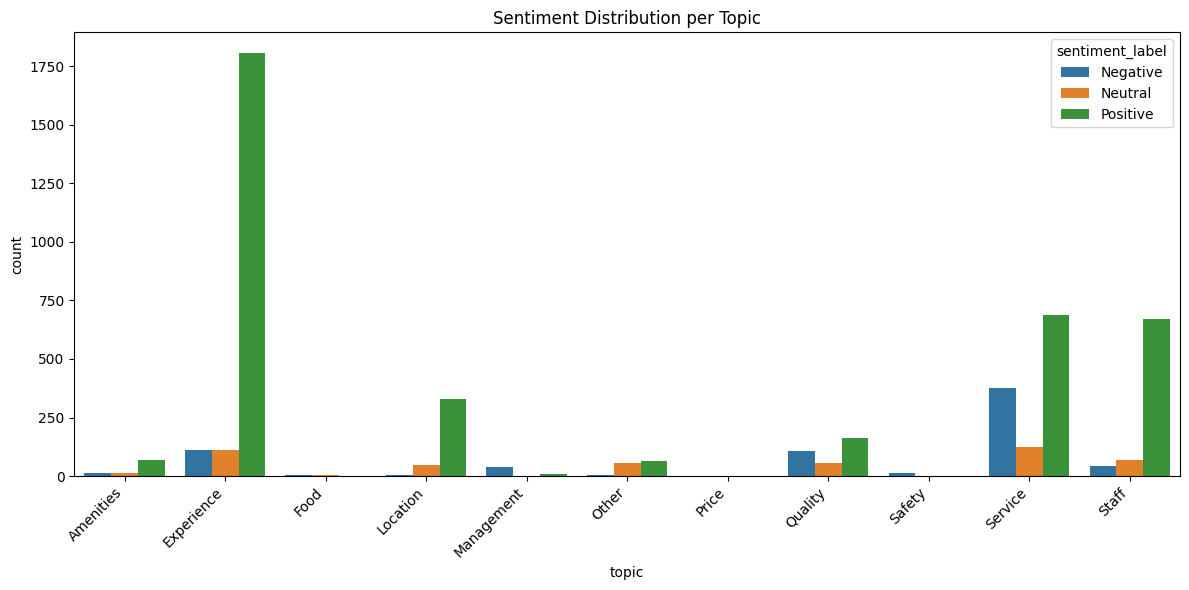

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

def categorize_sentiment(score):
    if score >= 0.4:
        return "Positive"
    elif score <= -0.4:
        return "Negative"
    else:
        return "Neutral"

reviews_df['sentiment_label'] = reviews_df['sentiment'].astype(float).apply(categorize_sentiment)

# Plot
plt.figure(figsize=(12, 6))
sentiment_counts = reviews_df.groupby(['topic', 'sentiment_label']).size().reset_index(name='count')
sns.barplot(data=sentiment_counts, x='topic', y='count', hue='sentiment_label')
plt.xticks(rotation=45, ha='right')
plt.title("Sentiment Distribution per Topic")
plt.tight_layout()
plt.show()

#### validation

In [234]:
reviews_df[reviews_df['sentiment'].isna()]

,review_text,reviews_id,sentiment,topic,support_text,translated_review_text,sentiment_label
10011,Disappointing Experience – Not Worth the Price...,10012,None,None,None,None,Neutral
995,My husband and I visited Sandals Curacao for o...,996,None,None,None,None,Neutral
11712,We had an amazing and incredibly relaxing 4 ni...,11713,None,None,None,None,Neutral


In [235]:
all_results.get(str(10011))

{'translated_text': 'Negatives- 1. Feels like everyone is doing you a favor here. 2. Room service never came (after waiting for 2 hours) 3. Checkout staff forced to charge my 4 year old for losing her bracelet 4. They ran out of water and beer and multiple other simple items at the bar multiple times. 5. Buffet was scarce one of the days where I couldn’t even find any protein without waiting in at least a 10 person line to get something. 6. Zero hospitality feeling. I don’t feel like a guest more so of a prisoner at this place. Benefits Beach is beautiful Kids pool is great Grounds are nice',
 'sentiment': -0.8,
 'topic': 'Service',
 'support_text': 'Zero hospitality feeling.'}

In [237]:
temp = reviews_df[reviews_df['sentiment'].isna()]
for rid in temp['reviews_id']:
    print(all_results.get(str(rid)))

{'error': 'Invalid JSON in GPT response', 'raw_content': '{"translated_text":"Disappointing Experience – Not Worth the Price  I stayed at Royalton CHIC Antigua in January 2025, booking the Luxury Presidential Sunset Overwater Suite Diamond Club expecting a premium, all-inclusive experience. Unfortunately, this resort fell short in multiple areas.  What Went Well: •\tThe room itself was nice and well-designed. •\tThe gym was well-equipped. •\tMy butler, Kemoy, was helpful and responsive.  What Went Wrong: •\tPre-Arrival Communication: I reached out multiple times via email and phone before my stay to arrange transportation and inquire about excursions. No one responded. •\tCheck-In Experience: The Diamond Club check-in area was messy, refreshments were stale with flies around them, and my room wasn’t ready on time. •\tDining & Food Quality: This was the worst part. The food at the Diamond Club breakfast buffet was old, and the fruit wasn’t fresh. Room service was disappointing, and over

In [ ]:
#create 2 cols
# 1. topic
# 2. topic category

# make topics broader not very restricted